In [1]:
import timm
import torch
import json
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, random_split, Dataset, random_split
from urllib.request import urlopen
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import itertools
from torch.utils.data import Dataset
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Subset
from sklearn.metrics import roc_auc_score as auc

/rds/general/user/ms7024/home/anaconda3/envs/breakhis/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Get one image for testing code
The size of images seems to be (700, 460) for all of them

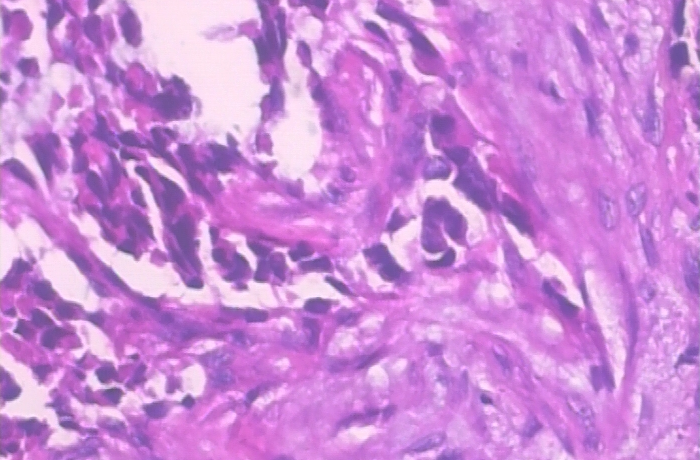

In [71]:
# testing on ONE image
image = Image.open("../data/toy_data/SOB_M_DC-14-14015-200-015.png").convert("RGB")
image

In [2]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),  # Converts to [0, 1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet stats
                         std=[0.229, 0.224, 0.225]),
])

#input_tensor = transform(image).unsqueeze(0) 
#print(input_tensor.shape)

# Load toy dataset

This one has 100 images. 

In [3]:
# Define custom dataset

class BreakHisDataset(Dataset): # Subclass Dataset, which is required for using DataLoader
    def __init__(self, csv_path, transform=None):
        self.df = pd.read_csv(csv_path)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.loc[idx, 'filepath']
        label = self.df.loc[idx, 'label']
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.long)
    
dataset = BreakHisDataset(csv_path="../data/toy_data/toy_metadata.csv", transform=transform) # Load the data


# Train test split

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create iterable data loaders

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False) # shuffle=False for consistent evaluation

In [55]:
# Load the pre-trained model

model = timm.create_model('convnextv2_atto.fcmae', pretrained=True, num_classes=2)
#model.head = torch.nn.Linear(model.num_features, 2) # set top layer to classify features
#model = model.eval()
print(model.head) # check that the output features are 2

NormMlpClassifierHead(
  (global_pool): SelectAdaptivePool2d(pool_type=avg, flatten=Identity())
  (norm): LayerNorm2d((320,), eps=1e-06, elementwise_affine=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (pre_logits): Identity()
  (drop): Dropout(p=0.0, inplace=False)
  (fc): Linear(in_features=320, out_features=2, bias=True)
)


# Training the first model on toy dataset
This model has all of the parameters frozen, except for the top layer which has two outputs for two classes. It has been tried on the toy data. It seems that, after 10 epochs, there was no improvement (accuracy for both train and test stays the same). 
After increasing the base learning rate for Adam from lr=1e-4 to lr=1e-3, this seemed to improve slightly (better accuracy on both train and test -  best ones are 0.875 and 0.85). 
It might be the case that the performance is limited because only the output layer parameters are being trained. Our dataset is different enough from ImageNet that it might be better to unfreeze and train the last few layers rather than just the final classification one. This is what I'll do next. 

In [8]:
# Freeze all layers & unfreeze just the classifier

for param in model.parameters():
    param.requires_grad = False
    
for param in model.head.parameters():
    param.requires_grad = True

# Train the model

criterion = nn.CrossEntropyLoss()
optimiser = optim.Adam(model.head.parameters(), lr=1e-3)

train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []

n_epochs = 20

for epoch in range(n_epochs):
    model.train()
    
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        optimiser.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimiser.step()
        
        running_loss += loss.item() * images.size(0) # Accumulate loss
        
        _, preds = torch.max(outputs, 1) # Take the maximum one as the class with the highest predicted probability => predicted class
        correct += (preds == labels).sum().item() # Number of correct predictions 
        total += labels.size(0) # adding correct predictions
        
    # Update training losses / accuracies
    
    epoch_train_loss = running_loss / total
    train_losses.append(epoch_train_loss)
    
    epoch_train_acc = correct / total
    train_accuracies.append(epoch_train_acc)
    
    # Evaluation phase
    
    model.eval()
    correct_val = 0
    total_val = 0
    running_val_loss = 0.0
    
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)
    
    epoch_val_acc = correct_val / total_val
    epoch_val_loss = running_val_loss / total_val
    val_accuracies.append(epoch_val_acc)
    val_losses.append(epoch_val_loss)
    
    print(f"Epoch [{epoch+1}/{n_epochs}], Train loss: {epoch_train_loss}, Test loss: {epoch_val_loss} Train accuracy: {epoch_train_acc}, Test accuracy: {epoch_val_acc}")
    

Epoch [1/20], Train loss: 0.6254259467124939, Test loss: 0.5786378502845764 Train accuracy: 0.6875, Test accuracy: 0.7
Epoch [2/20], Train loss: 0.6074141502380371, Test loss: 0.5566320180892944 Train accuracy: 0.6875, Test accuracy: 0.7
Epoch [3/20], Train loss: 0.579109400510788, Test loss: 0.5285271465778351 Train accuracy: 0.6875, Test accuracy: 0.7
Epoch [4/20], Train loss: 0.5556338846683502, Test loss: 0.5087601363658905 Train accuracy: 0.6875, Test accuracy: 0.65
Epoch [5/20], Train loss: 0.5452253758907318, Test loss: 0.4898244619369507 Train accuracy: 0.7125, Test accuracy: 0.7
Epoch [6/20], Train loss: 0.5352557957172394, Test loss: 0.47284737825393675 Train accuracy: 0.725, Test accuracy: 0.75
Epoch [7/20], Train loss: 0.5207833588123322, Test loss: 0.4632750391960144 Train accuracy: 0.7875, Test accuracy: 0.75
Epoch [8/20], Train loss: 0.5133659362792968, Test loss: 0.45163918733596803 Train accuracy: 0.8, Test accuracy: 0.75
Epoch [9/20], Train loss: 0.5101024150848389, T

# Gradual unfreezing of model layers
After unfreezing the latest stage, there is significant improvement in model performance (accuracy). 

In [36]:
# Check the high-level architecture

for name, module in model.named_children():
    print(name)

print(len(model.stages))    

stem
stages
norm_pre
head
4


In [41]:
stages_to_unfreeze = 1

n_stages = len(model.stages)

for i in range(n_stages - stages_to_unfreeze, n_stages):
    for param in model.stages[i].parameters():
        param.requires_grad = True
        
train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []

n_epochs = 20

for epoch in range(n_epochs):
    model.train()
    
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        optimiser.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimiser.step()
        
        running_loss += loss.item() * images.size(0) # Accumulate loss
        
        _, preds = torch.max(outputs, 1) # Take the maximum one as the class with the highest predicted probability => predicted class
        correct += (preds == labels).sum().item() # Number of correct predictions 
        total += labels.size(0) # adding correct predictions
        
    # Update training losses / accuracies
    
    epoch_train_loss = running_loss / total
    train_losses.append(epoch_train_loss)
    
    epoch_train_acc = correct / total
    train_accuracies.append(epoch_train_acc)
    
    # Evaluation phase
    
    model.eval()
    correct_val = 0
    total_val = 0
    running_val_loss = 0.0
    
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)
    
    epoch_val_acc = correct_val / total_val
    epoch_val_loss = running_val_loss / total_val
    val_accuracies.append(epoch_val_acc)
    val_losses.append(epoch_val_loss)
    
    print(f"Epoch [{epoch+1}/{n_epochs}], Train loss: {epoch_train_loss}, Test loss: {epoch_val_loss} Train accuracy: {epoch_train_acc}, Test accuracy: {epoch_val_acc}")

Epoch [1/20], Train loss: 0.4640969574451447, Test loss: 0.37857232689857484 Train accuracy: 0.85, Test accuracy: 0.85
Epoch [2/20], Train loss: 0.4620419144630432, Test loss: 0.37756450176239015 Train accuracy: 0.85, Test accuracy: 0.9
Epoch [3/20], Train loss: 0.4627187490463257, Test loss: 0.3725983023643494 Train accuracy: 0.8375, Test accuracy: 0.85
Epoch [4/20], Train loss: 0.4612491846084595, Test loss: 0.3717578947544098 Train accuracy: 0.85, Test accuracy: 0.9
Epoch [5/20], Train loss: 0.4578244984149933, Test loss: 0.37176904678344724 Train accuracy: 0.85, Test accuracy: 0.95
Epoch [6/20], Train loss: 0.45668189525604247, Test loss: 0.3700268387794495 Train accuracy: 0.85, Test accuracy: 0.95
Epoch [7/20], Train loss: 0.4551242768764496, Test loss: 0.36531010270118713 Train accuracy: 0.85, Test accuracy: 0.85
Epoch [8/20], Train loss: 0.45378586649894714, Test loss: 0.36325083374977113 Train accuracy: 0.875, Test accuracy: 0.85
Epoch [9/20], Train loss: 0.45362035632133485, T

In [46]:
stages_to_unfreeze = 2

n_stages = len(model.stages)

for i in range(n_stages - stages_to_unfreeze, n_stages):
    for param in model.stages[i].parameters():
        param.requires_grad = True
        
train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []

n_epochs = 20

for epoch in range(n_epochs):
    model.train()
    
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        optimiser.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimiser.step()
        
        running_loss += loss.item() * images.size(0) # Accumulate loss
        
        _, preds = torch.max(outputs, 1) # Take the maximum one as the class with the highest predicted probability => predicted class
        correct += (preds == labels).sum().item() # Number of correct predictions 
        total += labels.size(0) # adding correct predictions
        
    # Update training losses / accuracies
    
    epoch_train_loss = running_loss / total
    train_losses.append(epoch_train_loss)
    
    epoch_train_acc = correct / total
    train_accuracies.append(epoch_train_acc)
    
    # Evaluation phase
    
    model.eval()
    correct_val = 0
    total_val = 0
    running_val_loss = 0.0
    
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)
    
    epoch_val_acc = correct_val / total_val
    epoch_val_loss = running_val_loss / total_val
    val_accuracies.append(epoch_val_acc)
    val_losses.append(epoch_val_loss)
    
    print(f"Epoch [{epoch+1}/{n_epochs}], Train loss: {epoch_train_loss}, Test loss: {epoch_val_loss} Train accuracy: {epoch_train_acc}, Test accuracy: {epoch_val_acc}")

Epoch [1/20], Train loss: 0.44232974052429197, Test loss: 0.3612929880619049 Train accuracy: 0.85, Test accuracy: 0.95
Epoch [2/20], Train loss: 0.43904211521148684, Test loss: 0.3530648618936539 Train accuracy: 0.85, Test accuracy: 0.95
Epoch [3/20], Train loss: 0.438407102227211, Test loss: 0.3493811011314392 Train accuracy: 0.8625, Test accuracy: 0.95
Epoch [4/20], Train loss: 0.439752584695816, Test loss: 0.34751527905464175 Train accuracy: 0.875, Test accuracy: 0.9
Epoch [5/20], Train loss: 0.43757973313331605, Test loss: 0.35454014539718626 Train accuracy: 0.8625, Test accuracy: 0.95
Epoch [6/20], Train loss: 0.4358612596988678, Test loss: 0.3583782374858856 Train accuracy: 0.85, Test accuracy: 0.95
Epoch [7/20], Train loss: 0.43962836265563965, Test loss: 0.347471809387207 Train accuracy: 0.85, Test accuracy: 0.95
Epoch [8/20], Train loss: 0.4338267982006073, Test loss: 0.3533956825733185 Train accuracy: 0.8625, Test accuracy: 0.95
Epoch [9/20], Train loss: 0.43509520292282106, 

In [ ]:
# Creating a loop for gradually unfreezing layers

In [28]:
n_epochs = 5

models = ['Head only', 'Stage 4', 'Stages 3-4', 'Stages 2-4', 'Stages 1-4']
perf_train = pd.DataFrame(index=range(n_epochs), columns=models)
perf_test = pd.DataFrame(index=range(n_epochs), columns=models)

# Initialise loss criterion & optimiser
criterion = nn.CrossEntropyLoss()

# Sequentially unfreeze stages from top down

n_stages = 4

for i in range(n_stages+1):
    
    # Initialise model
    
    model = timm.create_model('convnextv2_atto.fcmae', pretrained=True, num_classes=2)
    optimiser = optim.Adam(
        [p for p in model.parameters() if p.requires_grad], 
        lr=1e-4)
    
    for param in model.parameters():
        param.requires_grad = False
        
    for param in model.head.parameters():
        param.requires_grad = True
    
    n_stages_to_unfreeze = i
    print(f' {i}. Stages to unfreeze: {i}')
    
    # Unfreeze stages
    for a in range(n_stages - n_stages_to_unfreeze, n_stages):
        for param in model.stages[a].parameters():
            param.requires_grad = True
    
    # Initialise tracking 
    
    train_accuracies = []
    test_accuracies = []
    train_losses = []
    test_losses = []
    
    for epoch in range(n_epochs):
        
        model.train()
        
        running_loss = 0
        correct = 0
        total = 0
        
        for images, labels in train_loader:
            optimiser.zero_grad()
            pred = model(images) # forward pass
            loss = criterion(pred, labels) 
            loss.backward() # updates model.grad with partial derivatives calc via chain rule
            optimiser.step() # take a step in negative direction of grad using calculated derivatives
            
            running_loss += loss.item() * images.size(0) # Accumulate loss per batch
            
            _, preds = torch.max(pred, 1) # Take the maximum one as the class with the highest predicted probability => predicted class
            
            correct += (preds == labels).sum().item()
            total += labels.size(0)
        
        epoch_train_loss = running_loss/total
        train_losses.append(epoch_train_loss)
        
        epoch_train_accuracy = correct/total 
        train_accuracies.append(epoch_train_accuracy)
        
        model.eval()
        
        running_loss_test = 0
        correct_test = 0
        total_test = 0
        
        with torch.no_grad():
            for images, labels in test_loader:
                pred = model(images)
                loss = criterion(pred, labels)
                running_loss_test += loss.item() * images.size(0)
                _, preds = torch.max(pred,1)
                
                correct_test += (preds == labels).sum().item()
                total_test += labels.size(0)
            
            
        test_losses.append(running_loss_test/total_test)
            
        epoch_test_accuracy = correct_test/total_test
        test_accuracies.append(epoch_test_accuracy)
        
        print(f"Epoch {epoch+1}/{n_epochs}: Train Accuracy {epoch_train_accuracy}, Test Accuracy {epoch_test_accuracy}")
    
    perf_train.iloc[:,i] = train_accuracies
    perf_test.iloc[:,i] = test_accuracies

perf_train.to_csv('convnext_v2_outputs/arc_perf_train_toy.csv')
perf_test.to_csv('convnext_v2_outputs/arc_perf_test_toy.csv')

 0. Stages to unfreeze: 0
Epoch 1/10: Train Accuracy 0.675, Test Accuracy 0.7
Epoch 2/10: Train Accuracy 0.775, Test Accuracy 0.6
Epoch 3/10: Train Accuracy 0.7125, Test Accuracy 0.6
Epoch 4/10: Train Accuracy 0.7125, Test Accuracy 0.6
Epoch 5/10: Train Accuracy 0.7125, Test Accuracy 0.6
Epoch 6/10: Train Accuracy 0.7125, Test Accuracy 0.6
Epoch 7/10: Train Accuracy 0.7125, Test Accuracy 0.6
Epoch 8/10: Train Accuracy 0.7125, Test Accuracy 0.6
Epoch 9/10: Train Accuracy 0.7125, Test Accuracy 0.6
Epoch 10/10: Train Accuracy 0.7125, Test Accuracy 0.6
 1. Stages to unfreeze: 1
Epoch 1/10: Train Accuracy 0.7125, Test Accuracy 0.6
Epoch 2/10: Train Accuracy 0.7125, Test Accuracy 0.6
Epoch 3/10: Train Accuracy 0.7125, Test Accuracy 0.6
Epoch 4/10: Train Accuracy 0.7625, Test Accuracy 0.7
Epoch 5/10: Train Accuracy 0.8125, Test Accuracy 0.7
Epoch 6/10: Train Accuracy 0.8625, Test Accuracy 0.7
Epoch 7/10: Train Accuracy 0.9, Test Accuracy 0.7
Epoch 8/10: Train Accuracy 0.8875, Test Accuracy 0.

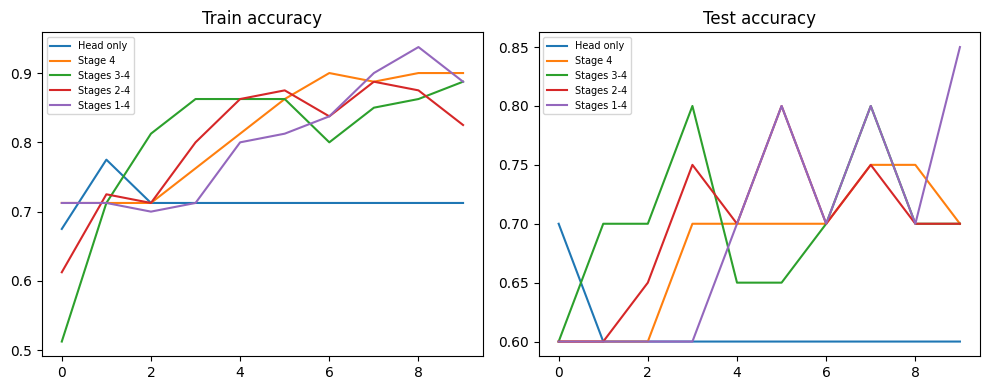

In [47]:
# Plotting accuracy for test

f, ax = plt.subplots(nrows = 1, ncols=2, figsize = (10, 4))

for i, df in enumerate([perf_train, perf_test]):
    
    for col in df.columns:
        ax[i].plot(range(l), df.loc[:, col], label = col)
    
    if i == 0:
        ax[i].set_title("Train accuracy")
    else:
        ax[i].set_title("Test accuracy")
    
    ax[i].legend(prop={'size': 7})

plt.tight_layout()
plt.show()


# Multi-class diagnosis prediction
The lowest count class is 15% of the highest one. Still, for now, accuracy will be used to guide the unfreezing level

In [5]:
df = pd.read_csv("../data/augmented_train_dataset.csv")
df['tumor_subtype'].value_counts()

tumor_subtype
ductal_carcinoma       1961
fibroadenoma           1142
tubular_adenoma         596
phyllodes_tumor         520
adenosis                486
mucinous_carcinoma      474
lobular_carcinoma       334
papillary_carcinoma     307
Name: count, dtype: int64

In [12]:
# Load dataset with diagnoses instead of labels





# Define custom dataset

class BreakHisDataset(Dataset): # Subclass Dataset, which is required for using DataLoader
    def __init__(self, csv_path, transform=None):
        self.df = pd.read_csv(csv_path)
        self.transform = transform
        self.le = LabelEncoder()
        self.df['label_diagnosis'] = self.le.fit_transform(self.df['tumor_subtype'])
        self.class_names = list(self.le.classes_)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.loc[idx, 'filepath']
        label = self.df.loc[idx, 'label']
        subtype = self.df.loc[idx, 'label_diagnosis']   
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.long), torch.tensor(subtype, dtype=torch.long)

# Decode predictions into class names (example)
dataset = BreakHisDataset(csv_path="../data/toy_data/toy_metadata.csv", transform=transform) # Load the data
pred_class_index = 0
class_name = dataset.class_names[pred_class_index]

# Train test split

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create iterable data loaders

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False) # shuffle=False for consistent evaluation

In [24]:
# NON-PARALLELISED LOOP 

n_epochs = 5
models = ['Head only', 'Stage 4', 'Stages 3-4', 'Stages 2-4', 'Stages 1-4']
n_stages = 4
criterion = nn.CrossEntropyLoss()

perf_train = pd.DataFrame(index=range(n_epochs), columns=models)
perf_test = pd.DataFrame(index=range(n_epochs), columns=models)

for i in range(n_stages+1):
    
    # Initialise model
    
    model = timm.create_model('convnextv2_atto.fcmae', pretrained=True, num_classes=8)

    for param in model.parameters(): # Freeze all
        param.requires_grad = False
        
    for param in model.head.parameters(): # Unfreeze head
        param.requires_grad = True
    n_stages_to_unfreeze = i
    print(f' {i}. Stages to unfreeze: {i}')

    for a in range(n_stages - n_stages_to_unfreeze, n_stages): # Unfreeze stages
        for param in model.stages[a].parameters():
            param.requires_grad = True
    
    optimiser = optim.Adam([p for p in model.parameters() if p.requires_grad],lr=1e-4)
    
    # Initialise tracking 
    
    train_accuracies = []
    test_accuracies = []
    train_losses = []
    test_losses = []
    
    for epoch in range(n_epochs):
        
        model.train()
        
        running_loss = 0
        correct = 0
        total = 0
        
        for images, _, labels in train_loader:
            optimiser.zero_grad()
            pred = model(images) # forward pass
            loss = criterion(pred, labels) 
            loss.backward() # updates model.grad with partial derivatives calc via chain rule
            optimiser.step() # take a step in negative direction of grad using calculated derivatives
            
            running_loss += loss.item() * images.size(0) # Accumulate loss per batch
            
            _, preds = torch.max(pred, 1) # Take the maximum one as the class with the highest predicted probability => predicted class
            
            correct += (preds == labels).sum().item()
            total += labels.size(0)
        
        epoch_train_loss = running_loss/total
        train_losses.append(epoch_train_loss)
        
        epoch_train_accuracy = correct/total 
        train_accuracies.append(epoch_train_accuracy)
        
        model.eval()
        
        running_loss_test = 0
        correct_test = 0
        total_test = 0
        
        with torch.no_grad():
            for images, _, labels in test_loader:
                pred = model(images)
                loss = criterion(pred, labels)
                running_loss_test += loss.item() * images.size(0)
                _, preds = torch.max(pred,1)
                
                correct_test += (preds == labels).sum().item()
                total_test += labels.size(0)
            
            
        test_losses.append(running_loss_test/total_test)
            
        epoch_test_accuracy = correct_test/total_test
        test_accuracies.append(epoch_test_accuracy)
        
        print(f"Epoch {epoch+1}/{n_epochs}: Train Accuracy {epoch_train_accuracy}, Test Accuracy {epoch_test_accuracy}")
    
    perf_train.iloc[:,i] = train_accuracies
    perf_test.iloc[:,i] = test_accuracies

 0. Stages to unfreeze: 0
Epoch 1/5: Train Accuracy 0.0375, Test Accuracy 0.05
Epoch 2/5: Train Accuracy 0.0375, Test Accuracy 0.05
Epoch 3/5: Train Accuracy 0.0375, Test Accuracy 0.05
Epoch 4/5: Train Accuracy 0.0375, Test Accuracy 0.05
Epoch 5/5: Train Accuracy 0.0375, Test Accuracy 0.05
 1. Stages to unfreeze: 1
Epoch 1/5: Train Accuracy 0.2625, Test Accuracy 0.45
Epoch 2/5: Train Accuracy 0.3625, Test Accuracy 0.45
Epoch 3/5: Train Accuracy 0.3625, Test Accuracy 0.45
Epoch 4/5: Train Accuracy 0.3625, Test Accuracy 0.45
Epoch 5/5: Train Accuracy 0.45, Test Accuracy 0.45
 2. Stages to unfreeze: 2
Epoch 1/5: Train Accuracy 0.3125, Test Accuracy 0.45
Epoch 2/5: Train Accuracy 0.3625, Test Accuracy 0.45
Epoch 3/5: Train Accuracy 0.3625, Test Accuracy 0.45
Epoch 4/5: Train Accuracy 0.4375, Test Accuracy 0.5
Epoch 5/5: Train Accuracy 0.5375, Test Accuracy 0.55
 3. Stages to unfreeze: 3
Epoch 1/5: Train Accuracy 0.2375, Test Accuracy 0.45
Epoch 2/5: Train Accuracy 0.3625, Test Accuracy 0.4

# Hyperparameter tuning
The "Stages 2-4 model performs the best for the binary task, as 

In [ ]:
# NON-PARALLELISED LOOP 

n_epochs = 5
n_stages = 4
criterion = nn.CrossEntropyLoss()

# Hyperparameter configs 

hyperparams = {
    'lr': [1e-3, 1e-4, 1e-5],
    'optimizer': ['adam', 'sgd'],
    'batch_size': [16, 32],
    'weight_decay': [0, 1e-4]
}

keys = hyperparams.keys()
values = hyperparams.values()
all_configs = []
for prod in itertools.product(*values): # Make all combinations of parameters
    config = dict(zip(keys, prod))
    all_configs.append(config)

config_cols = []
for i in range(len(all_configs)):
    config_cols.append(f"Config_{i}")
    
perf_train = pd.DataFrame(index=range(n_epochs), columns=config_cols)
perf_test = pd.DataFrame(index=range(n_epochs), columns=config_cols)

# Loop - not parallelised
for i, config in enumerate(all_configs):
    
    print(f"Config {i}: {config}")
    # Initialise model
    
    model = timm.create_model('convnextv2_atto.fcmae', pretrained=True, num_classes=8)
    for param in model.parameters(): # Freeze all
        param.requires_grad = False  
    for param in model.head.parameters(): # Unfreeze head
        param.requires_grad = True
    for a in range(1, 4):
        for param in model.stages[a].parameters():
            param.requires_grad = True
    
    if config['optimizer'] == 'adam':
        optimiser = optim.Adam([p for p in model.parameters() if p.requires_grad],lr=config['lr'], weight_decay = config['weight_decay'])
    elif config['optimizer'] == 'sgd':
        optimiser = optim.SGD([p for p in model.parameters() if p.requires_grad], lr=config['lr'], weight_decay = config['weight_decay'])
    else:
        raise ValueError(f"Optimiser {config['optimizer']} not recognised")
    
    train_loader_inloop = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
    test_loader_inloop = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False)
    # Initialise tracking 
    
    train_accuracies = []
    test_accuracies = []
    train_losses = []
    test_losses = []
    
    for epoch in range(n_epochs):
        
        model.train()
        
        running_loss = 0
        correct = 0
        total = 0
        
        for images, labels, _ in train_loader_inloop:
            optimiser.zero_grad()
            pred = model(images) # forward pass
            loss = criterion(pred, labels) 
            loss.backward() # updates model.grad with partial derivatives calc via chain rule
            optimiser.step() # take a step in negative direction of grad using calculated derivatives
            
            running_loss += loss.item() * images.size(0) # Accumulate loss per batch
            
            _, preds = torch.max(pred, 1) # Take the maximum one as the class with the highest predicted probability => predicted class
            
            correct += (preds == labels).sum().item()
            total += labels.size(0)
        
        epoch_train_loss = running_loss/total
        train_losses.append(epoch_train_loss)
        
        epoch_train_accuracy = correct/total 
        train_accuracies.append(epoch_train_accuracy)
        
        model.eval()
        
        running_loss_test = 0
        correct_test = 0
        total_test = 0
        
        with torch.no_grad():
            for images, labels, _ in test_loader_inloop:
                pred = model(images)
                loss = criterion(pred, labels)
                running_loss_test += loss.item() * images.size(0)
                _, preds = torch.max(pred,1)
                
                correct_test += (preds == labels).sum().item()
                total_test += labels.size(0)
            
        test_losses.append(running_loss_test/total_test)
            
        epoch_test_accuracy = correct_test/total_test
        test_accuracies.append(epoch_test_accuracy)
                         
        print(f"Epoch {epoch+1}/{n_epochs}: Train Accuracy {epoch_train_accuracy}, Test Accuracy {epoch_test_accuracy}")
    
    perf_train.iloc[:,i] = train_accuracies
    perf_test.iloc[:,i] = test_accuracies

In [57]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


# Cross-validation

In [11]:
# Load data

class BreakHisDataset(Dataset): # Subclass Dataset, which is required for using DataLoader
    def __init__(self, csv_path, transform=None):
        self.df = pd.read_csv(csv_path)
        self.transform = transform
        self.le = LabelEncoder()
        self.df['label_diagnosis'] = self.le.fit_transform(self.df['tumor_subtype'])
        self.class_names = list(self.le.classes_)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.loc[idx, 'filepath']
        label = self.df.loc[idx, 'label']
        subtype = self.df.loc[idx, 'label_diagnosis']   
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.long), torch.tensor(subtype, dtype=torch.long)
    
data = BreakHisDataset(csv_path="../data/toy_data/toy_metadata.csv", transform=transform)





In [ ]:


perfcols = ['Fold', 'Epoch', 'Train_Loss', 'Train_Acc', 'Train_Recall', 'Train_Spec', 'Train_F1', 'Train_AUC',
          'Test_Loss', 'Test_Acc', 'Test_Recall', 'Test_Spec', 'Test_F1', 'Test_AUC' ]

df = pd.DataFrame(columns = perfcols)
n_epochs = 5

params = {'lr': 0.0001, 'optimizer': 'adam', 'batch_size': 32, 'weight_decay': 0}

y = data.df['label']
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for idx, (train_idx, test_idx) in enumerate(skf.split(range(len(data)), y)):
    print(f"CV iteration {idx+1}")
    model = timm.create_model('convnextv2_atto.fcmae', pretrained=True, num_classes=2)
    for param in model.parameters(): # Freeze all
        param.requires_grad = False  
    for param in model.head.parameters(): # Unfreeze head
        param.requires_grad = True
    for a in range(1, 4):
        for param in model.stages[a].parameters():
            param.requires_grad = True
    
    optimizer = optim.Adam([p for p in model.parameters() if p.requires_grad],lr=params['lr'], weight_decay = params['weight_decay'])
    criterion = nn.CrossEntropyLoss()

    train = Subset(data, train_idx)
    train_loader = DataLoader(train, batch_size=params['batch_size'], shuffle=True)
    test = Subset(data, test_idx)
    test_loader = DataLoader(test, batch_size=params['batch_size'], shuffle=True)
    
    train_loss = []
    test_loss = []
    train_acc = []
    test_acc = []
    train_recall = []
    test_recall = []
    train_spec = []
    test_spec = []
    train_f1= []
    test_f1= []
    train_auc= []
    test_auc= []
    
    train_labels_list = []
    train_probs_list = []
    test_labels_list = []
    test_probs_list = []
    
    for epoch in range(n_epochs):
        model.train()
        running_loss = 0
        total = 0
        tp = 0
        tn = 0
        fp = 0
        fn = 0
        
        for image, label, _ in train_loader:
            
            optimizer.zero_grad()
            pred = model(image)
            probs = torch.softmax(pred, dim=1)[:,1]
            train_probs_list.append(probs)
            train_labels_list.append(label)
            loss = criterion(pred, label)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * image.size(0)
            _, preds = torch.max(pred, 1)
            label = label.long()
            preds = preds.long()
            tp += ((preds == 1) & (label == 1)).sum().item()
            tn += ((preds == 0) & (label == 0)).sum().item()
            fp += ((preds == 1) & (label == 0)).sum().item()
            fn += ((preds == 0) & (label == 1)).sum().item()
            total += label.size(0)
        
        all_train_labels = torch.cat(train_labels_list).detach().numpy()
        all_train_probs  = torch.cat(train_probs_list).detach().numpy()
        auc_train = auc(all_train_labels, all_train_probs)
        
        metric_lists_train = [train_loss, train_acc, train_recall, train_spec, train_f1, train_auc]
        metrics_train = [running_loss/total, (tp+tn)/total, tp/(tp+fn), tn/(tn+fp), tp/(tp+0.5*(fp+tn)), auc_train]
        
        for i in range(len(metric_lists_train)):
            metric_lists_train[i].append(metrics_train[i])
        
#         train_loss.append(running_loss/total)
#         train_acc.append((tp+tn)/total)
#         train_recall.append(tp/(tp+fn))
#         train_spec.append(tn/(tn+fp))
#         train_f1.append(tp/(tp+0.5(fp+tn)))
        
        model.eval()
        running_loss_test = 0
        total_test = 0
        tp_test = 0
        tn_test = 0
        fp_test = 0
        fn_test = 0
        
        for image, label, _ in test_loader:
            pred = model(image)
            loss = criterion(pred, label)
            _, preds = torch.max(pred, 1)
            probs = torch.softmax(pred, dim=1)[:,1]
            test_probs_list.append(probs)
            test_labels_list.append(label)
            running_loss_test += loss.item() * image.size(0)
            label = label.long()
            preds = preds.long()
            tp_test += ((preds == 1) & (label == 1)).sum().item()
            tn_test += ((preds == 0) & (label == 0)).sum().item()
            fp_test += ((preds == 1) & (label == 0)).sum().item()
            fn_test += ((preds == 0) & (label == 1)).sum().item()
            total_test += label.size(0)
        
        
        all_test_labels = torch.cat(test_labels_list).detach().numpy()
        all_test_probs  = torch.cat(test_probs_list).detach().numpy()
        auc_test = auc(all_test_labels, all_test_probs)
        
        metric_lists_test = [test_loss, test_acc, test_recall, test_spec, test_f1, test_auc]
        metrics_test = [running_loss_test/total_test, (tp_test+tn_test)/total_test, tp_test/(tp_test+fn_test), 
                   tn_test/(tn_test+fp_test), tp_test/(tp_test+0.5*(fp_test+tn_test)), auc_test]
        
        for i in range(len(metric_lists_test)):
            metric_lists_test[i].append(metrics_test[i])
        
        row = pd.DataFrame(data=[[f"Fold{idx+1}", f"Epoch{epoch+1}"] + metrics_train + metrics_test], columns = perfcols)
        df = pd.concat([df, row]).reset_index(drop=True)
        print(df)
        #print(f"Epoch {epoch+1}/{n_epochs}: Train Accuracy {(tp+tn)/total}, Test Accuracy {(tp_test+tn_test)/total_test}")
        
        
            


### Create the stratified folds to be used as json
This enables parallelisation, as the folds (with corresponding indexes) are created and stored a priori, so each of the folds can be ran/fit in parallel.

In [150]:
folder = 'convnext_v2_outputs'

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
folds = []

for train_idx, val_idx in skf.split(X=range(len(df)), y=df['label']):
    folds.append({
        'train_idx': train_idx.tolist(),
        'val_idx': val_idx.tolist()
    })

with open(f"{folder}/convnextv2_cv_folds.json", "w") as f:
    json.dump(folds, f)
    
perfcols = ['Fold', 'Epoch', 'Train_Loss', 'Train_Acc', 'Train_Recall', 'Train_Spec', 'Train_F1', 'Train_AUC',
          'Test_Loss', 'Test_Acc', 'Test_Recall', 'Test_Spec', 'Test_F1', 'Test_AUC' ]

df = pd.DataFrame(columns = perfcols)
df.to_csv(f"{folder}/cv_perf.csv") # Also save dataframe to enable performance tracking

In [152]:
# Test

job = 1

with open(f"{folder}/convnextv2_cv_folds.json", "r") as f:
    folds = json.load(f)

# Example: get train/val indices for fold 2
train_idx = folds[job]['train_idx']
val_idx = folds[job]['val_idx']
print(len(train_idx)+len(val_idx))

7303


In [133]:
df1 = pd.read_csv("../data/augmented_train_dataset.csv", index_col = 'Unnamed: 0')
df2 = pd.read_csv("../data/new_test.csv", index_col = 'Unnamed: 0')
df2 = df2[ df2.columns[2:]]
print(df1.columns)
print(df2.columns)

df = pd.concat([df1, df2], ignore_index=True)
df.to_csv("../data/aug_train_test_remerge.csv")
df3 = pd.read_csv("../data/aug_train_test_remerge.csv")
print(df3.columns)
df3.head

Index(['filepath', 'label', 'magnification', 'tumor_subtype'], dtype='object')
Index(['filepath', 'label', 'magnification', 'tumor_subtype'], dtype='object')


array([ True,  True,  True,  True])

In [154]:
df = pd.read_csv('convnext_v2_outputs/cv_perf.csv', index_col = 'Unnamed: 0')
df.columns

Index(['Fold', 'Epoch', 'Train_Loss', 'Train_Acc', 'Train_Recall',
       'Train_Spec', 'Train_F1', 'Train_AUC', 'Test_Loss', 'Test_Acc',
       'Test_Recall', 'Test_Spec', 'Test_F1', 'Test_AUC'],
      dtype='object')

### Do the same for multiclass performance
Slightly different approach to performance: the same csv as above is saved per class 

In [4]:
# Make CSV 
folder = 'convnext_v2_outputs/array_job_output_CV_milticlass'

perfcols = ['Fold', 'Epoch', 'Train_Loss', 'Train_Acc', 'Train_Recall', 'Train_Spec', 'Train_F1', 'Train_AUC',
          'Test_Loss', 'Test_Acc', 'Test_Recall', 'Test_Spec', 'Test_F1', 'Test_AUC' ]

df = pd.DataFrame(columns = perfcols)
for i in range(8):
    df.to_csv(f"{folder}/cv_perf_class{i+1}.csv") # Also save dataframe to enable performance tracking

# Final model train
Train the final model on the augumented train + track performance with validation set, and finally assess performance on the holdout set

In [7]:
# Save a new csv
folder = 'convnext_v2_outputs/Single_Model'

perfcols = ['Epoch', 'Train_Loss', 'Train_Acc', 'Train_Recall', 'Train_Spec', 'Train_F1', 'Train_AUC',
          'Test_Loss', 'Test_Acc', 'Test_Recall', 'Test_Spec', 'Test_F1', 'Test_AUC' ]

df = pd.DataFrame(columns = perfcols)
#df.to_csv(f"{folder}/Single_model_binary.csv")

In [74]:
params = {'lr': 0.0001, 'optimizer': 'adam', 'batch_size': 32, 'weight_decay': 0}

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),  # Converts to [0, 1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet stats
                         std=[0.229, 0.224, 0.225]),
])

class BreakHisDataset(Dataset): # Subclass Dataset, which is required for using DataLoader
    def __init__(self, csv_path, transform=None):
        self.df = pd.read_csv(csv_path)
        self.transform = transform
        self.le = LabelEncoder()
        self.df['label_diagnosis'] = self.le.fit_transform(self.df['tumor_subtype'])
        self.class_names = list(self.le.classes_)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.loc[idx, 'filepath']
        label = self.df.loc[idx, 'label']
        subtype = self.df.loc[idx, 'label_diagnosis']   
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.long), torch.tensor(subtype, dtype=torch.long)

# For testing on toy
# dataset = BreakHisDataset(csv_path="../data/toy_data/toy_metadata.csv", transform=transform) # Load the data
# train_size = int(0.8 * len(dataset))
# test_size = len(dataset) - train_size
# train, test = random_split(dataset, [train_size, test_size])

# For full dataset
# train = BreakHisDataset(csv_path="../data/augmented_train_dataset.csv", transform=transform) # Load the data
# test = BreakHisDataset(csv_path="../data/new_test.csv", transform=transform)

# For original data
gradcam = BreakHisDataset(csv_path="../data/metadata.csv", transform=transform)

train_loader = DataLoader(train, batch_size=params['batch_size'], shuffle=True)
gradcam_loader = DataLoader(test, batch_size=params['batch_size'], shuffle=True)

# Extract class names and map to results

In [8]:
label_mapping = {i: class_name for i, class_name in enumerate(train.class_names)}
print(label_mapping)

{0: 'adenosis', 1: 'ductal_carcinoma', 2: 'fibroadenoma', 3: 'lobular_carcinoma', 4: 'mucinous_carcinoma', 5: 'papillary_carcinoma', 6: 'phyllodes_tumor', 7: 'tubular_adenoma'}


In [13]:
holdout_perclass = pd.read_csv("convnext_v2_outputs/Single_Model/Multiclass/Holdout_perclass.csv", index_col = 'Unnamed: 0')
holdout_perclass['Class'] = holdout_perclass['Class'].map(label_mapping)
holdout_perclass.to_csv("convnext_v2_outputs/Single_Model/Multiclass/Holdout_perclass.csv")

In [3]:
from sklearn.metrics import confusion_matrix
import numpy as np
from sklearn.metrics import roc_auc_score as auc

n_epochs = 30

df = pd.read_csv(f"{folder}/Single_model_binary.csv", index_col = 'Unnamed: 0') # tracking performance
df = pd.DataFrame(columns = df.columns)

model = timm.create_model('convnextv2_atto.fcmae', pretrained=True, num_classes=2)
for param in model.parameters(): # Freeze all
    param.requires_grad = False  
for param in model.head.parameters(): # Unfreeze head
    param.requires_grad = True
for a in range(1, 4):
    for param in model.stages[a].parameters():
        param.requires_grad = True

optimizer = optim.Adam([p for p in model.parameters() if p.requires_grad],lr=params['lr'], weight_decay = params['weight_decay'])
criterion = nn.CrossEntropyLoss()

train_loss = []
test_loss = []
train_acc = []
test_acc = []
train_recall = []
test_recall = []
train_spec = []
test_spec = []
train_f1= []
test_f1= []
train_auc= []
test_auc= []

# Define values for early stopping

patience      = 3                   # how many epochs to wait
best_val_loss = float('inf')        # “best so far”
counter       = 0                   # epochs since last improvement
best_weights  = None  

for epoch in range(n_epochs):
   
    train_labels_list = []
    train_probs_list = []
    train_preds_list = []

    model.train()
    running_loss = 0

    for image, label, _ in train_loader:

        optimizer.zero_grad()
        outputs = model(image)
        probs = torch.softmax(outputs, dim=1)[:,1]
        train_probs_list.append(probs)
        train_labels_list.append(label)
        loss = criterion(outputs, label)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * image.size(0)
        _, preds = torch.max(outputs, 1)
        train_preds_list.append(preds)
        label = label.long()
        preds = preds.long()
    
    all_train_labels = torch.cat(train_labels_list).detach().numpy()
    all_train_probs  = torch.cat(train_probs_list).detach().numpy()
    all_train_preds = torch.cat(train_preds_list).detach().numpy()

    cm = confusion_matrix(all_train_labels, all_train_preds)
    total = cm.sum()
    auc_train = auc(all_train_labels, all_train_probs)
    
    tp = cm[1,1]
    fn = cm[1, 0]
    fp = cm[0,1]
    tn = cm[0,0]
    rec = tp/(tp+fn) if (tp+fn) >0 else 0
    spec = tn/(tn+fp) if (tn+fp) >0 else 0
    f1 = tp / (tp+0.5*(fp+fn)) if (tp+0.5*(fp+fn))>0 else 0
    


    metric_lists_train = [train_loss, train_acc, train_recall, train_spec, train_f1, train_auc]
    metrics_train = [running_loss/total, (tp+tn)/total, rec, spec, f1, auc_train]

    for i in range(len(metric_lists_train)):
        metric_lists_train[i].append(metrics_train[i])
    
    model.eval()
    
    running_loss_test = 0
    total_test = 0
    test_labels_list = []
    test_probs_list = []
    test_preds_list = []
    
    with torch.no_grad():
        for image, label, _ in test_loader:
            
            outputs = model(image)
            probs = torch.softmax(outputs, dim=1)[:,1]
            test_probs_list.append(probs)
            test_labels_list.append(label)
            loss = criterion(outputs, label)
            running_loss_test += loss.item() * image.size(0)
            _, preds = torch.max(outputs, 1)
            test_preds_list.append(preds)
            label = label.long()
            preds = preds.long()

        all_test_labels = torch.cat(test_labels_list).detach().numpy()
        all_test_probs  = torch.cat(test_probs_list).detach().numpy()
        all_test_preds = torch.cat(test_preds_list).detach().numpy()
        
        cm = confusion_matrix(all_test_labels, all_test_preds)
        total_test = cm.sum()
        auc_test = auc(all_test_labels, all_test_probs)
        
        tp_test = cm[1,1]
        fn_test = cm[1, 0]
        fp_test = cm[0,1]
        tn_test = cm[0,0]
        rec_test = tp_test/(tp_test+fn_test) if (tp_test+fn_test) >0 else 0
        spec_test = tn_test/(tn_test+fp_test) if (tn_test+fp_test) >0 else 0
        f1_test = tp_test / (tp_test+0.5*(fp_test+fn_test)) if (tp_test+0.5*(fp_test+fn_test))>0 else 0

        
        metric_lists_test = [test_loss, test_acc, test_recall, test_spec, test_f1, test_auc]
        metrics_test = [running_loss_test/total_test, (tp_test+tn_test)/total_test, rec_test, spec_test, f1_test, auc_test]

        for i in range(len(metric_lists_test)):
            metric_lists_test[i].append(metrics_test[i])
    
    row = pd.DataFrame(data=[[f"Epoch{epoch+1}"] + metrics_train + metrics_test], columns = perfcols)
    df = pd.concat([df, row]).reset_index(drop=True)
    print(f"Epoch {epoch+1}/{n_epochs}: Train Accuracy {(tp+tn)/total}, Test Accuracy {(tp_test+tn_test)/total_test}")
    
    val_loss = running_loss_test/total_test
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        best_weights = model.state_dict()
    else:
        counter += 1
        print(f"No improvement in validation loss for {counter} epochs")
        if counter >= patience:
            print(f"Stopping early at epoch {epoch+1}")
            break
if best_weights is not None:
    model.load_state_dict(best_weights)
    print("Loaded best model from the epoch with lowest val_loss")
    torch.save(model.state_dict(), f"convnext_v2_outputs/Single_Model/best_model_test.pth")

#df.to_csv(f"{folder}/Single_model_binary.csv")
df

NameError: name 'folder' is not defined

/rds/general/user/ms7024/home/anaconda3/envs/breakhis/lib/python3.10/site-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


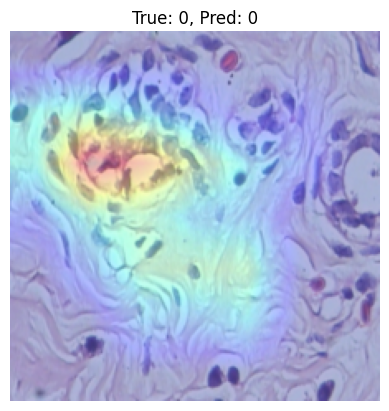

In [41]:
del iter

In [18]:
print(last_block)

Sequential(
  (0): ConvNeXtBlock(
    (conv_dw): Conv2d(320, 320, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=320)
    (norm): LayerNorm2d((320,), eps=1e-06, elementwise_affine=True)
    (mlp): GlobalResponseNormMlp(
      (fc1): Conv2d(320, 1280, kernel_size=(1, 1), stride=(1, 1))
      (act): GELU()
      (drop1): Dropout(p=0.0, inplace=False)
      (grn): GlobalResponseNorm()
      (fc2): Conv2d(1280, 320, kernel_size=(1, 1), stride=(1, 1))
      (drop2): Dropout(p=0.0, inplace=False)
    )
    (shortcut): Identity()
    (drop_path): Identity()
  )
  (1): ConvNeXtBlock(
    (conv_dw): Conv2d(320, 320, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=320)
    (norm): LayerNorm2d((320,), eps=1e-06, elementwise_affine=True)
    (mlp): GlobalResponseNormMlp(
      (fc1): Conv2d(320, 1280, kernel_size=(1, 1), stride=(1, 1))
      (act): GELU()
      (drop1): Dropout(p=0.0, inplace=False)
      (grn): GlobalResponseNorm()
      (fc2): Conv2d(1280, 320, kernel_size=(

In [ ]:
# Evaluate on test / holdout set 

holdout = BreakHisDataset(csv_path="../data/new_holdout.csv", transform=transform)
holdout_loader = DataLoader(holdout, batch_size=params['batch_size'], shuffle=False)

model.eval()
all_labels = []
all_probs = []
all_preds = []
running_loss = 0

with torch.no_grad():
    for image, label, _ in holdout_loader:
        outputs = model(image)
        all_labels.append(label)
        probs = torch.softmax(outputs, dim=1)[:,1]
        all_probs.append(probs)
        _, preds = torch.max(outputs, 1)
        all_preds.append(preds)
        running_loss += criterion(outputs, label).item() * label.size(0)

all_holdout_labels = torch.cat(all_labels).detach().numpy()
all_holdout_probs  = torch.cat(all_probs).detach().numpy()
all_holdout_preds = torch.cat(all_preds).detach().numpy()

cm_holdout = confusion_matrix(all_holdout_labels, all_holdout_preds)
total_holdout = cm_holdout.sum()
auc_holdout = auc(all_holdout_labels, all_holdout_probs)

tp_holdout = cm_holdout[1,1]
fn_holdout = cm_holdout[1, 0]
fp_holdout = cm_holdout[0,1]
tn_holdout = cm_holdout[0,0]
rec_holdout = tp_holdout/(tp_holdout+fn_holdout) if (tp_holdout+fn_holdout) >0 else 0
spec_holdout = tn_holdout/(tn_holdout+fp_holdout) if (tn_holdout+fp_holdout) >0 else 0
f1_holdout = tp_holdout / (tp_holdout+0.5*(fp_holdout+fn_holdout)) if (tp_holdout+0.5*(fp_holdout+fn_holdout))>0 else 0 

percols_h = ['Loss', 'Accuracy', 'Recall', 'Specificity', 'F1', 'AUC']
perf_row = [running_loss/total_holdout, (tp_holdout+tn_holdout)/total_holdout, 
           rec_holdout, spec_holdout, f1_holdout, auc_holdout]

perf_h = pd.DataFrame(data = [perf_row], columns = perfcols_h )  

# Grad-CAM
XAI feature

In [14]:
model = timm.create_model('convnextv2_atto.fcmae', pretrained=False, num_classes=2)
model.load_state_dict(torch.load("convnext_v2_outputs/Single_Model/best_model_binary.pth"))
model.eval()

ConvNeXt(
  (stem): Sequential(
    (0): Conv2d(3, 40, kernel_size=(4, 4), stride=(4, 4))
    (1): LayerNorm2d((40,), eps=1e-06, elementwise_affine=True)
  )
  (stages): Sequential(
    (0): ConvNeXtStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): ConvNeXtBlock(
          (conv_dw): Conv2d(40, 40, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=40)
          (norm): LayerNorm2d((40,), eps=1e-06, elementwise_affine=True)
          (mlp): GlobalResponseNormMlp(
            (fc1): Conv2d(40, 160, kernel_size=(1, 1), stride=(1, 1))
            (act): GELU()
            (drop1): Dropout(p=0.0, inplace=False)
            (grn): GlobalResponseNorm()
            (fc2): Conv2d(160, 40, kernel_size=(1, 1), stride=(1, 1))
            (drop2): Dropout(p=0.0, inplace=False)
          )
          (shortcut): Identity()
          (drop_path): Identity()
        )
        (1): ConvNeXtBlock(
          (conv_dw): Conv2d(40, 40, kernel_size=(7, 7), stride=(1, 1), 

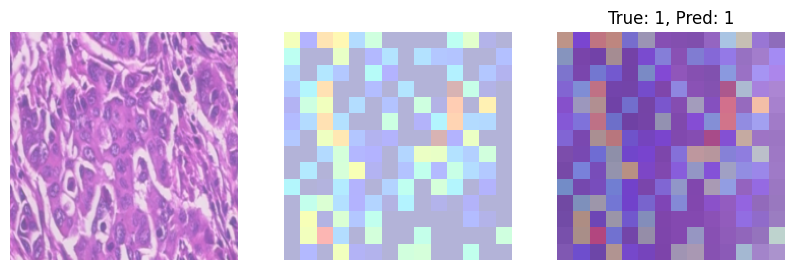

In [109]:
# Grad-CAM

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

def generate_gradcam(model, input_tensor, target_class, target_layer):
    model.eval()

    # 1. Store feature maps and gradients
    activations = []
    gradients = []

    def forward_hook(module, input, output): # capture feature maps of that layer
        activations.append(output.detach())

    def backward_hook(module, grad_input, grad_output): # capture gradients of output score wrt each feature map
        gradients.append(grad_output[0].detach())

    # 2. Register hooks
    forward_handle = target_layer.register_forward_hook(forward_hook)
    backward_handle = target_layer.register_backward_hook(backward_hook)

    # 3. Forward pass
    output = model(input_tensor) # output
    pred_class = output.argmax(dim=1).item() # extract logit for class=1 (malignant)

    # 4. Backward pass for target class
    model.zero_grad()
    class_score = output[:, target_class]
    class_score.backward() # Compute dy/DA where A it output, A is feature map (matrix)

    # 5. Remove hooks
    forward_handle.remove()
    backward_handle.remove()

    # 6. Get the stored activations and gradients
    grad = gradients[0]         # shape: [B, C, H, W]
    act = activations[0]        # shape: [B, C, H, W]
    weights = grad.mean(dim=(2, 3), keepdim=True)  # global average pooling

    # 7. Compute weighted combination
    cam = (weights * act).sum(dim=1, keepdim=True)
    cam = F.relu(cam)
    #cam = F.interpolate(cam, size=input_tensor.shape[2:], mode='bilinear', align_corners=False)

    # 8. Normalize for visualization
    cam = cam.squeeze().cpu().numpy()
    cam = (cam - cam.min()) / (cam.max() - cam.min())

    return cam, pred_class

# choose target layer

target_layer = list(model.stages[2].children())[-1][1] # change stages[X] to look at different layers

# Get a batch from test_loader
img_iter = iter(gradcam_loader)
image_batch, label_batch, _ = next(img_iter)
image = image_batch[0].unsqueeze(0)
label = label_batch[0].item()

# Run Grad-CAM
cam, pred_class = generate_gradcam(model, image, target_class=0, target_layer=target_layer)

# Denormalise image
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

def denormalize(tensor, mean, std):
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    return tensor * std + mean

image_denorm = denormalize(image, mean, std)
# Visualize

f, ax = plt.subplots(nrows = 1, ncols=3, figsize = (10, 4))
ax[0].imshow(to_pil_image(image_denorm.squeeze()))
ax[1].imshow(cam, cmap='jet', alpha=0.3)
ax[2].imshow(to_pil_image(image_denorm.squeeze()))
ax[2].imshow(cam, cmap='jet', alpha=0.3)
plt.title(f"True: {label}, Pred: {pred_class}")
for i in range(3):
    ax[i].axis('off')
plt.show()

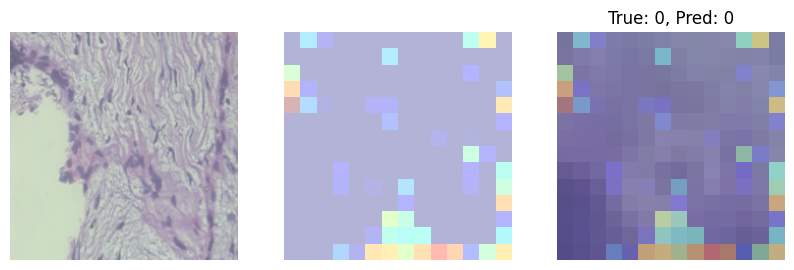

In [105]:
target_layer = list(model.stages[2].children())[-1][1]

# Get a batch from test_loader
#img_iter = iter(gradcam_loader)
image_batch, label_batch, _ = next(img_iter)
image = image_batch[0].unsqueeze(0)
label = label_batch[0].item()

# Run Grad-CAM
cam, pred_class = generate_gradcam(model, image, target_class=0, target_layer=target_layer)

# Denormalise image
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

def denormalize(tensor, mean, std):
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    return tensor * std + mean

image_denorm = denormalize(image, mean, std)
# Visualize

f, ax = plt.subplots(nrows = 1, ncols=3, figsize = (10, 4))
ax[0].imshow(to_pil_image(image_denorm.squeeze()))
ax[1].imshow(cam, cmap='jet', alpha=0.3)
ax[2].imshow(to_pil_image(image_denorm.squeeze()))
ax[2].imshow(cam, cmap='jet', alpha=0.3)
plt.title(f"True: {label}, Pred: {pred_class}")
for i in range(3):
    ax[i].axis('off')
plt.show()

In [102]:
target_layer

ConvNeXtBlock(
  (conv_dw): Conv2d(160, 160, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=160)
  (norm): LayerNorm2d((160,), eps=1e-06, elementwise_affine=True)
  (mlp): GlobalResponseNormMlp(
    (fc1): Conv2d(160, 640, kernel_size=(1, 1), stride=(1, 1))
    (act): GELU()
    (drop1): Dropout(p=0.0, inplace=False)
    (grn): GlobalResponseNorm()
    (fc2): Conv2d(640, 160, kernel_size=(1, 1), stride=(1, 1))
    (drop2): Dropout(p=0.0, inplace=False)
  )
  (shortcut): Identity()
  (drop_path): Identity()
)